# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before

But how do you get your own data into PyTorch?

One of the ways to do is via : custom datasets.

## Domain libraries
Dpeneding on what you're working on, vision, text, audio. recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions

**Resources :**
* Book version of the course materials for 04 : https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

# 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

print(torch.__version__)

2.5.1+cu124


In [2]:
!nvidia-smi

Mon Aug 11 14:02:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.153.02             Driver Version: 570.153.02     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   59C    P8              9W /   35W |      45MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# setup agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

our datasets is a subset of the Food101 dataset

Food 101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary

The whole point is to speed up how fast you can experiment

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("../Datasets/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it..
if image_path.is_dir():
    print(f"{image_path} exists, skipping download")
else:
    print(f"{image_path} does not exist")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza steak sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza_steak_sushi.zip")
    f.write(requests.content)

# unzip pissa sushi steak data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza_steak_sushi.zip")
    zip_ref.extractall(image_path)

../Datasets/pizza_steak_sushi exists, skipping download
Unzipping pizza_steak_sushi.zip


## 2. Becoming one with the data (data preperation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
    """
    walks through dir_path returning its contents
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '../Datasets/pizza_steak_sushi'.
There are 3 directories and 0 images in '../Datasets/pizza_steak_sushi/test'.
There are 0 directories and 25 images in '../Datasets/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in '../Datasets/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in '../Datasets/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in '../Datasets/pizza_steak_sushi/train'.
There are 0 directories and 78 images in '../Datasets/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in '../Datasets/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in '../Datasets/pizza_steak_sushi/train/sushi'.


In [7]:
# setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('../Datasets/pizza_steak_sushi/train'),
 PosixPath('../Datasets/pizza_steak_sushi/test'))

## 2.1 Visualize an image

write code for
1. get all of the image paths
2. pick a random path using python's random.choice()
3. get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with python's PIL
5. we'll then show the image and print metadata

sushi
Random image path : ../Datasets/pizza_steak_sushi/train/sushi/929471.jpg
Image class : sushi
Image height : 512
Image width : 511


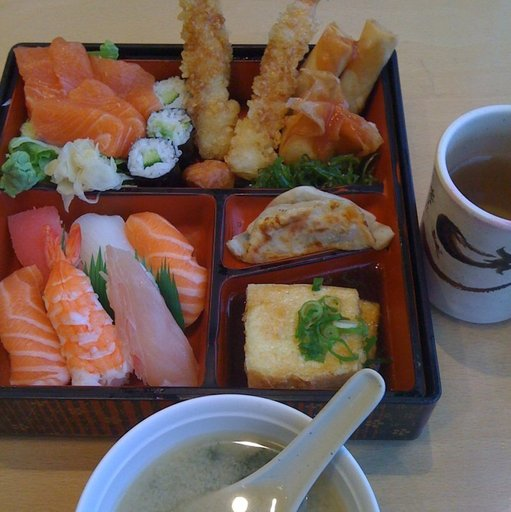

In [8]:
import random
from PIL import Image

# set seed
# random.seed(42)

# 1. get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)

# 3. get the image class from the path name (the image class is the name of the dir where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print meta data
print(f"Random image path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")
img

(np.float64(-0.5), np.float64(510.5), np.float64(511.5), np.float64(-0.5))

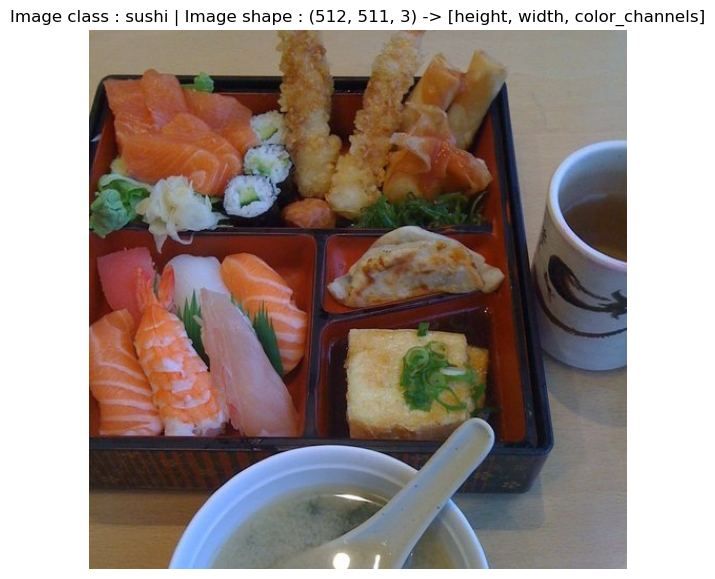

In [9]:
# use matplotlib
import matplotlib.pyplot as plt
import numpy as np

# turn the image into an array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class : {image_class} | Image shape : {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)


In [10]:
img_as_array

array([[[155, 138, 110],
        [157, 140, 112],
        [158, 141, 115],
        ...,
        [145, 154, 151],
        [145, 154, 151],
        [145, 154, 149]],

       [[155, 138, 110],
        [156, 139, 111],
        [158, 141, 115],
        ...,
        [144, 153, 150],
        [143, 152, 149],
        [143, 152, 149]],

       [[153, 138, 109],
        [154, 139, 110],
        [155, 140, 111],
        ...,
        [144, 153, 152],
        [144, 153, 150],
        [143, 152, 149]],

       ...,

       [[132, 107,  66],
        [131, 106,  65],
        [129, 104,  63],
        ...,
        [154, 151, 162],
        [158, 155, 166],
        [159, 153, 165]],

       [[132, 108,  64],
        [131, 107,  63],
        [131, 107,  63],
        ...,
        [155, 149, 161],
        [157, 151, 163],
        [156, 150, 162]],

       [[131, 107,  61],
        [131, 107,  61],
        [132, 108,  64],
        ...,
        [153, 147, 159],
        [156, 150, 162],
        [156, 150, 162]]

## 3. Transforming data

Before we can use our image data with PyTorch:
1. turn your target data into tensors (in our case, numerical representation of our images)
2. turn it into a `torch.utils.data.Dataset` and subsequently a `torch.util.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation - https://docs.pytorch.org/vision/stable/transforms.html

In [19]:
data_transform = transforms.Compose([
    # resize image
    transforms.Resize(size=(64, 64)),
    # flipping
    transforms.RandomHorizontalFlip(p=0.5),
    # turn to tensors
    transforms.ToTensor(),
])

In [20]:
data_transform(img).dtype

torch.float32

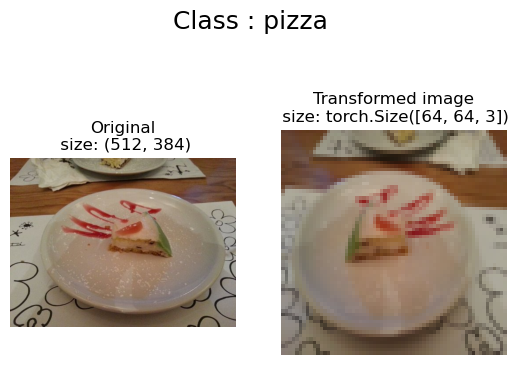

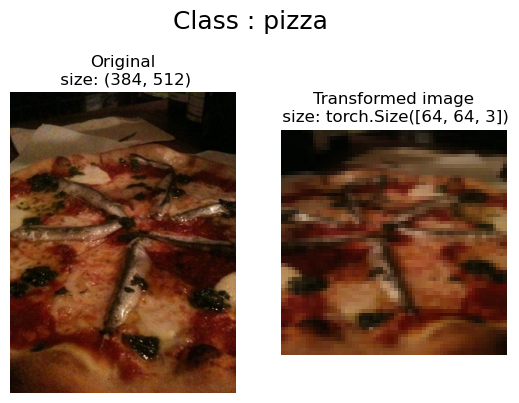

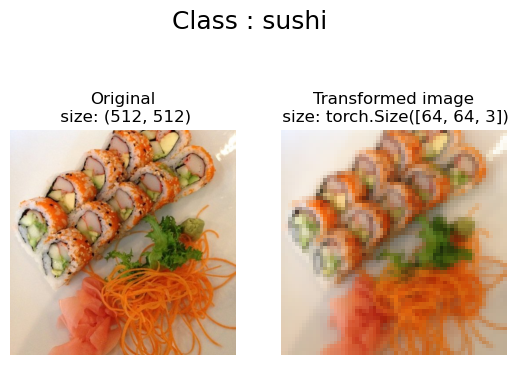

In [23]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
    """
    Selects random images from a path of images and loads/tranforms them then plots the original vs transformed version
    :param image_paths:
    :param transform:
    :param n:
    :param seed:
    :return:
    """
    if seed :
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\n size: {f.size}")
            ax[0].axis(False)

            # transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed image\n size: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class : {image_path.parent.stem}", fontsize=18)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load imgae classification using `torchvision.datasets.ImgaeFolder` - https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [24]:
# use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: ../Datasets/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: ../Datasets/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [25]:
train_dir, test_dir

(PosixPath('../Datasets/pizza_steak_sushi/train'),
 PosixPath('../Datasets/pizza_steak_sushi/test'))

In [26]:
# see classes names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [27]:
# see classes names but in index
index_class_names = train_data.class_to_idx
index_class_names

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [36]:
train_data.targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]